<a href="https://colab.research.google.com/github/cbwoyak/CLRS/blob/main/TPS/Dec-2021/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 2.51 ms (started: 2021-12-26 00:06:56 +00:00)


In [ ]:
# Allow custom module imports from Google Drive
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/modules')

Mounted at /content/gdrive
time: 37.7 s (started: 2021-12-26 00:06:56 +00:00)


In [ ]:
# install and setup Kaggle API
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=608c2a6318fcc46593bd29c6c4c10e4dbe2797a614e9c5aada28681ba7b1537f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
time: 5.91 s (started: 2021-12-26 00:07:34 +00:00)


In [ ]:
# Download kaggle competition files
%env COMP=tabular-playground-series-dec-2021
!kaggle competitions download -c $COMP
!unzip ${COMP}.zip

env: COMP=tabular-playground-series-dec-2021
 90% 113M/126M [00:02<00:00, 42.2MB/s] 
100% 126M/126M [00:02<00:00, 51.5MB/s]
Archive:  tabular-playground-series-dec-2021.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
time: 8.68 s (started: 2021-12-26 00:07:40 +00:00)


In [ ]:
import pandas as pd
import numpy as np
import math
import imblearn

from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier  #KNN
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.tree import DecisionTreeClassifier #DT
from sklearn.ensemble import BaggingClassifier #Bagging
from sklearn.ensemble import GradientBoostingClassifier #Gradient boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import kaggle_utils


time: 1.32 s (started: 2021-12-26 00:19:02 +00:00)


# sklearn utilities

In [ ]:
def cross_validate(clf, dataset, folds=5, shuffle=False):
  if shuffle:
    cv = ShuffleSplit(n_splits=folds, test_size=0.25, random_state=0)
    score = cross_val_score(clf, dataset.X(), dataset.Y(), cv=cv, verbose=10).mean()
  else:
    score = cross_val_score(clf, dataset.X(), dataset.Y(), cv=folds, verbose=10).mean()

  print("Average score: {:.5f}".format(score))


time: 4.08 ms (started: 2021-12-26 00:19:07 +00:00)


In [ ]:
def param_search(clf, X, Y, params, folds=2, shuffle=False):
  search = GridSearchCV(clf, param_grid=params, cv=folds)
  if shuffle:
    cv = ShuffleSplit(n_splits=folds, test_size=0.25, random_state=0)
    search = GridSearchCV(clf, param_grid=params, verbose=3, cv=cv, scoring=['f1_macro', 'balanced_accuracy'], refit=False)
    
  search.fit(X, Y)
  return search.cv_results_

time: 5.85 ms (started: 2021-12-26 00:19:10 +00:00)


In [ ]:
class CvResults():
  def __init__(self, results):
    self.data = results

  def keys(self):
    return self.data.keys()

  def get_param_names(self):
    return list(self['params'][0].keys())

  def get_experiment(self, idx):
    if idx < 0 or idx > self.experiment_count():
      return None
    return self['params'][idx]

  def experiment_count(self):
    return len(self['params'])

  def get_score_names(self):
    return [score[len('rank_test_'):] for score in self.keys() if score.startswith('rank_test_')]

  def get_best_experiment(self, criteria):
    if criteria not in self.get_score_names():
      return None

    key = 'rank_test_' + criteria
    idx = np.where(self[key] == 1)[0][0]
    print(type(idx))
    print(idx)
    return self.get_experiment(idx)

  def get_param_values(self, param):
    values = set(self[f'param_{param}'])
    return sorted(list(values))

  def plot(self, param1, param2, score):
    if score not in self.get_score_names():
      print("bad score")
      return
    if param1 not in self.get_param_names():
      print("bad param: {}".format(param1))
      return
    if param2 not in self.get_param_names():
      print("bad param: {}".format(param2))
      return

    x_values = self.get_param_values(param1)
    y_values = self.get_param_values(param2)
    data = self[f'mean_test_{score}'].reshape((len(y_values), len(x_values)))

    # plot param1 vs param 2 and score values using matplotlib
    fig, ax = plt.subplots(1)
    ax.imshow(data)
    ax.set_xticks(np.arange(len(x_values)))
    ax.set_yticks(np.arange(len(y_values)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['{:.3f}'.format(x) if isinstance(x, float) else x for x in x_values])
    ax.set_yticklabels(['{:.3f}'.format(x) if isinstance(x, float) else x for x in y_values])

    plt.xlabel(param1)
    plt.ylabel(param2)

    max = np.amax(data)
    max_diff = max - np.amin(data)
    for i in range(len(y_values)):
        for j in range(len(x_values)):
          color = 'w'
          diff = max - data[i,j]
          if (diff < 0.4 * max_diff):
            # in the top 40%, so change the color so the text can be seen more 
            # clearly with the default colormap
            color = '#000000'
          text = ax.text(j, i, '{:.3f}'.format(data[i, j]),
                        ha="center", va="center", color=color)
            
    ax.set_title(score)

    fig.tight_layout()
    fig.set_size_inches(25, 10)
    plt.show()

  def __getitem__(self, key):
    return self.data[key]


time: 76.2 ms (started: 2021-12-26 00:19:11 +00:00)


---

# Pandas Utils

In [ ]:
def rescale(old_min, old_max, new_min, new_max, value):
  return (value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

# rescales the specified dataframe column so that all values are within min and max
def scale_column(df, column, nmin=None, nmax=None):
  orig_min = df[column].min()
  orig_max = df[column].max()
  if nmax is None:
    new_max = orig_max
  else:
    new_max = min(orig_max, nmax)

  if nmin is None:
    new_min = orig_min
  else:
    new_min = max(orig_min, nmin)
  df[column] = (df[column] - orig_min) / (orig_max - orig_min) * (new_max - new_min) + new_min

def remove_column(df, column):
  df = df.drop([column], axis=1)

time: 9.52 ms (started: 2021-12-26 00:19:14 +00:00)


# Scratchpad

In [ ]:
dataset = kaggle_utils.KaggleDataset('train.csv', 'test.csv', True)

time: 12.8 s (started: 2021-12-26 00:19:18 +00:00)


In [ ]:
def clean_data(df):
  scale_column(df, 'Aspect', 0, 359.99)
  scale_column(df, 'Slope', 0, 90)
  scale_column(df, 'Horizontal_Distance_To_Hydrology', 0)
  scale_column(df, 'Vertical_Distance_To_Hydrology', 0)
  scale_column(df, 'Horizontal_Distance_To_Roadways', 0)
  scale_column(df, 'Hillshade_9am', 0, 255)
  scale_column(df, 'Hillshade_Noon', 0, 255)
  scale_column(df, 'Hillshade_3pm', 0, 255)
  scale_column(df, 'Horizontal_Distance_To_Fire_Points', 0)
  remove_column(df, 'Soil_Type7')
  remove_column(df, 'Soil_Type15')

time: 5.42 ms (started: 2021-12-26 00:23:20 +00:00)


In [ ]:




dataset._train = dataset._train[dataset._train.Cover_Type != 5]
clean_data(dataset._train)
clean_data(dataset._test)

time: 6.23 s (started: 2021-12-26 00:23:26 +00:00)


In [ ]:
for cls in dataset.class_list():
  print("Class: {}, Samples: {}".format(cls, dataset.get_sample_count(cls)))


Class: 1, Samples: 1468136
Class: 2, Samples: 2262087
Class: 3, Samples: 195712
Class: 6, Samples: 11426
Class: 7, Samples: 62261
Class: 4, Samples: 377
time: 162 ms (started: 2021-12-26 00:23:38 +00:00)


# Decision Tree

In [ ]:
clf = DecisionTreeClassifier(class_weight='balanced', criterion="gini")
params = {"max_depth": range(5, 50)}
results = param_search(clf, dataset.X(), dataset.Y(), params, 2, True)
r = CvResults(results)

In [ ]:
clf = DecisionTreeClassifier(class_weight='balanced', criterion="entropy", max_depth=49)
clf.fit(dataset.X(), dataset.Y())
dataset.predict_clf(clf)

time: 2min 13s (started: 2021-12-23 14:14:37 +00:00)


# Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(class_weight='balanced')
params = {"max_depth": range(2, 15),
          "n_estimators": range(5, 56, 5)}
results = param_search(clf, dataset.X(), dataset.Y(), params, 2, True)
r = CvResults(results)

Fitting 2 folds for each of 143 candidates, totalling 286 fits
[CV 1/2] END max_depth=2, n_estimators=5; balanced_accuracy: (test=0.499) f1_macro: (test=0.106) total time=  19.0s
[CV 2/2] END max_depth=2, n_estimators=5; balanced_accuracy: (test=0.619) f1_macro: (test=0.243) total time=  16.6s
[CV 1/2] END max_depth=2, n_estimators=10; balanced_accuracy: (test=0.691) f1_macro: (test=0.364) total time=  29.5s
[CV 2/2] END max_depth=2, n_estimators=10; balanced_accuracy: (test=0.638) f1_macro: (test=0.323) total time=  27.7s
[CV 1/2] END max_depth=2, n_estimators=15; balanced_accuracy: (test=0.644) f1_macro: (test=0.283) total time=  40.1s
[CV 2/2] END max_depth=2, n_estimators=15; balanced_accuracy: (test=0.640) f1_macro: (test=0.274) total time=  39.7s
[CV 1/2] END max_depth=2, n_estimators=20; balanced_accuracy: (test=0.628) f1_macro: (test=0.315) total time=  49.4s
[CV 2/2] END max_depth=2, n_estimators=20; balanced_accuracy: (test=0.653) f1_macro: (test=0.304) total time=  52.2s
[CV

In [ ]:
clf = RandomForestClassifier(max_samples=20000, n_estimators=100, max_depth=9, class_weight='balanced_subsample')
clf.fit(dataset.X(), dataset.Y())
dataset.predict_clf(clf)

time: 1min 45s (started: 2021-12-22 01:03:13 +00:00)


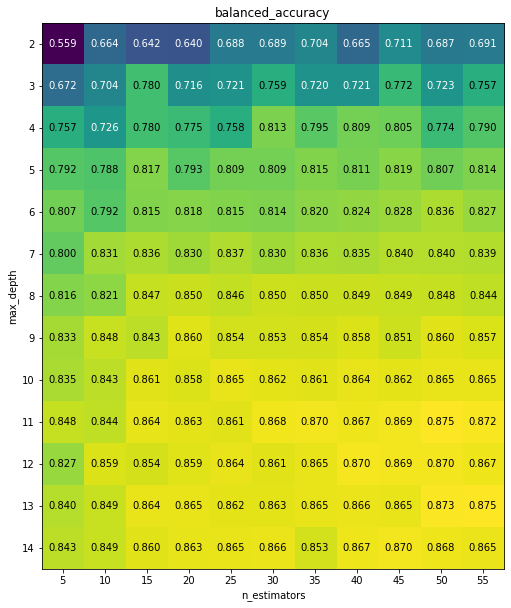

time: 790 ms (started: 2021-12-26 18:26:58 +00:00)


In [ ]:
r = CvResults(results)
r.plot('n_estimators', 'max_depth', 'balanced_accuracy')

In [ ]:
dataset._train = dataset._train[dataset._train['Cover_Type'] != 5]
from imblearn.ensemble import BalancedRandomForestClassifier
clf = BalancedRandomForestClassifier(max_samples=20000, random_state=0)
params = {"max_depth": range(5, 15),
          "n_estimators": range(10, 101, 10)}
results = param_search_xy(clf, dataset.X(), dataset.Y(), params, 2, True)


Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END max_depth=5, n_estimators=10; balanced_accuracy: (test=0.707) f1_macro: (test=0.303) total time=  25.6s
[CV 2/2] END max_depth=5, n_estimators=10; balanced_accuracy: (test=0.751) f1_macro: (test=0.352) total time=  23.2s
[CV 1/2] END max_depth=5, n_estimators=20; balanced_accuracy: (test=0.763) f1_macro: (test=0.360) total time=  38.2s
[CV 2/2] END max_depth=5, n_estimators=20; balanced_accuracy: (test=0.789) f1_macro: (test=0.387) total time=  38.5s
[CV 1/2] END max_depth=5, n_estimators=30; balanced_accuracy: (test=0.794) f1_macro: (test=0.412) total time=  52.3s
[CV 2/2] END max_depth=5, n_estimators=30; balanced_accuracy: (test=0.804) f1_macro: (test=0.418) total time=  53.0s
[CV 1/2] END max_depth=5, n_estimators=40; balanced_accuracy: (test=0.800) f1_macro: (test=0.414) total time= 1.1min
[CV 2/2] END max_depth=5, n_estimators=40; balanced_accuracy: (test=0.806) f1_macro: (test=0.408) total time= 1.1min
[

KeyboardInterrupt: ignored

time: 1h 21min 19s (started: 2021-12-22 02:57:32 +00:00)


In [ ]:

clf = BalancedRandomForestClassifier(max_samples=20000, random_state=0, max_depth=7, n_estimators=80)
clf.fit(dataset.X(), dataset.Y())
dataset.predict_clf(clf)

time: 2min 48s (started: 2021-12-22 04:19:12 +00:00)


In [ ]:
clf = GradientBoostingClassifier(random_state=0, n_estimators=100, learning_rate=0.5, max_depth=5)
clf.fit(dataset.X(), dataset.Y())
dataset.predict_clf(clf)

time: 3min 51s (started: 2021-12-17 01:56:47 +00:00)


In [ ]:
clf = AdaBoostClassifier(n_estimators=500, learning_rate=0.25, random_state=0)
score = cross_val_score(clf, dataset.X(), dataset.Y(), cv=3, verbose=10).mean()
print(score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.543) total time= 3.9min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


KeyboardInterrupt: ignored

In [ ]:
#print(clf.n_classes_)
print(clf.n_estimators)

200


In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3, max_depth=5, random_state=0, subsample=0.1)
score = cross_val_score(clf, dataset.X(), dataset.Y(), cv=3, verbose=10).mean()
print(score)


In [ ]:
clf.fit(dataset.X(), dataset.Y())

(1000000, 1)
(1000000, 1)
